# Project Overview: 


## Collaborators:

1. Agnes Chomba

2. Derrick Malinga

3. Erick Okacha

4. Judah Odida

5. Lucas Ominde

6. Nick  Mwai

7. Olgah Omollo

# FinComBot - Compliance Chatbot 

## 1. Background
Financial institutions face increasing pressure to comply with stringent regulatory frameworks governing customer onboarding, Know Your Customer (KYC), Customer Due Diligence (CDD), Enhanced Due Diligence (EDD), Anti-Money Laundering (AML), Counter Terrorism Financing, Counter Proliferation Financing (CPF), and sanctions screening. These obligations are complex, continuously evolving, and vary across jurisdictions.

Staff often face difficulties accessing and interpreting regulatory documents and internal policies, leading to:
-	Delays in onboarding, affecting customer experience and revenue.
-	Inconsistent application of compliance procedures.
-	Overdependence on compliance officers for basic guidance.
-	Increased risk of regulatory breaches which may lead to fining by regulators and put the bank at risk of its license being suspended.





#  2. Business Objective

a.)  Build a chatbot that retrieves accurate compliance information 
from the bank’s KYC/AML/CTF/CPF policies and responds to staff queries.



## 3. Target Audience

a.) Front office / Relationship Managers (who onboard customers)

b.)  Operations staff (who process documents)

c.) Compliance officers (for guidance validation)

d.) New staff (as a training tool)

e.) Risk & Audit teams (for oversight)


##  4. Data Understanding
Data Source: 
a. Internal compliance policy, stored in Word (.docx) format,  Contains: KYC procedures, AML red flags, CDD/EDD checklists, risk rating methodology, regulatory guidelines (FATF, CBK, CMA)

Data Characteristics:Unstructured text (paragraphs, checklists), Multiple sections (policies, procedures, workflows), Needs preprocessing before AI ingestion


### 1. Loading Data

In [ ]:
# importing libraries
import pandas as pd
import docx as docx
from docx.shared import Pt

import os
import pickle
import os
import matplotlib.pyplot as plt
import re
import unicodedata

import os, textwrap

# Ensure TensorFlow is disabled (avoids keras issues)
os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_TF"] = "1"

from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from docx import Document





### Load the raw document

This step involves loading the raw document, which is provided in .docx format. For the pilot phase of this project, the document used will be the Know Your Customer (KYC) Policy, serving as the reference material for testing and validating the document processing workflow.

In [ ]:
def load_docx(file_path):
    doc = Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs if para.text.strip()])

# Use the correct relative path
text = load_docx(r"Data\SEC5 - OPENING OF ACCOUNTS (004).docx.docx")
print(text[:500])  # preview first 500 characters


OPENING OF ACCOUNTS
TABLE OF CONTENTS
1	INTRODUCTION	11
1.1	General	11
2	ACCOUNT OPENING REQUIREMENTS	11
2.1	Know Your Customer (KYC)	11
2.2	Account Opening Requirements on Referee	11
2.3	Documentation Required for Account Opening	12
2.4	Account Opening Requirements for Foreign Nationals	34
2.4.1	Resident Foreign Nationals	34
2.4.2	Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines).	35
2.4.3	Minimum requirements for Resident Foreigners	35
2.4.4	Acc


### Data Preprocessing

This step involves cleaning and structuring the loaded document to prepare it for further analysis. Key tasks include removing unwanted characters, standardizing text formats, tokenizing content, and extracting relevant sections from the KYC policy. This ensures that the data is consistent, organized, and ready for downstream processing.


### Cleaning & normalize text 

In [3]:
print("Working dir:", os.getcwd()) # confirm working directory
print("Text variable exists:", 'text' in globals()) # confirm text variable is loaded

Working dir: c:\Users\Administrator\Documents\Phase 5\project 1\Group_5_Capstone_Project
Text variable exists: True


At this stage, we perform two quick checks before moving on with preprocessing. First, we confirm the working directory by calling os.getcwd(). This ensures that the project is being executed from the correct folder, so that relative paths such as Data/... will resolve properly. Next, we verify that the document content has been successfully loaded into memory. We do this by checking whether the variable text exists in the current environment using 'text' in globals(). If the output returns True, it means the raw .docx file has been read correctly and stored; if it returns False, we need to revisit the document loading step to ensure the data is available for further processin  



### Exploratory Document Statistics

In [19]:

orig = text  # your loaded document text
print("\n--- ORIGINAL STATS ---")
print("Characters:", len(orig))
print("Words:", len(orig.split()))
non_empty_lines = [L for L in orig.splitlines() if L.strip()]
print("Non-empty lines:", len(non_empty_lines))
print("\n--- PREVIEW (first 5000 chars) ---\n")
print(textwrap.fill(orig[:5000], width=120))



--- ORIGINAL STATS ---
Characters: 165696
Words: 26098
Non-empty lines: 2529

--- PREVIEW (first 5000 chars) ---

OPENING OF ACCOUNTS TABLE OF CONTENTS 1       INTRODUCTION    11 1.1     General 11 2       ACCOUNT OPENING REQUIREMENTS
11 2.1     Know Your Customer (KYC)        11 2.2     Account Opening Requirements on Referee 11 2.3     Documentation
Required for Account Opening      12 2.4     Account Opening Requirements for Foreign Nationals      34 2.4.1   Resident
Foreign Nationals      34 2.4.2   Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential
Guidelines).     35 2.4.3   Minimum requirements for Resident Foreigners    35 2.4.4   Account Opening Requirements for
Companies with Foreign Nationals as Directors  35 2.4.5   Account Opening Requirements for Temporary Residents
(Students, Spouses, Attaché’s to Foreign Missions in Kenya, Next Of Kin etc.)      36 2.4.6   Non-resident Foreigners 36
2.5     Account Opening Requirements for Scrap Meta

Once the raw document text has been successfully loaded, we generate some quick statistics to understand its structure and content. The variable orig stores the loaded text for reference. We then print the number of characters in the document using len(orig), followed by the total word count obtained through len(orig.split()). 

To check the overall formatting, we also calculate the number of non-empty lines by filtering out blank lines from the text. Finally, to get a sense of the document’s content without scrolling through the entire file, we display a preview of the first 1,000 characters, formatted neatly with textwrap.fill() for readability. This step provides a useful overview of the raw data before deeper preprocessing begins.

In [5]:
def clean_text(
    text,
    lowercase=False, # keep case by default (recommended for embeddings)
    remove_empty_lines=True,
    normalize_unicode=True,
    normalize_whitespace=True,
    remove_page_numbers=True
):
    """
    Clean and normalize a document string.

    - normalize_unicode: use NFKC normalization (fixes weird unicode forms)
    - remove_page_numbers: drop standalone numeric lines like "1" or "Page 1"
    - remove_empty_lines: remove empty/blank lines and collapse into paragraphs
    - normalize_whitespace: collapse repeated spaces/tabs/newlines
    - lowercase: optional - keep off by default (recommended: keep case for embeddings)
    """
    if normalize_unicode:
        text = unicodedata.normalize("NFKC", text)

    # Normalize line endings
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # Replace non-breaking spaces
    text = text.replace("\u00A0", " ")

    # Normalize common smart quotes to ascii quotes
    text = text.replace("“", '"').replace("”", '"').replace("‘", "'").replace("’", "'")

    # Remove unprintable control characters (keep \n and \t)
    text = "".join(ch for ch in text if ch.isprintable() or ch in "\n\t")

    # Optionally drop page headers/footers that look like "Page 1" or just "1"
    if remove_page_numbers:
        out_lines = []
        for line in text.split("\n"):
            s = line.strip()
            # common patterns to remove
            if re.fullmatch(r'page\s*\d+', s, flags=re.IGNORECASE):
                continue
            if re.fullmatch(r'\d{1,4}', s):  # standalone numbers (likely page numbers)
                continue
            out_lines.append(line)
        text = "\n".join(out_lines)

    # Trim each line, optionally remove empty lines and join paragraphs with a blank line
    if remove_empty_lines:
        lines = [line.strip() for line in text.split("\n")]
        lines = [line for line in lines if line != ""]  # drop blank lines
        # join paragraphs with a double newline (keeps paragraph boundaries)
        text = "\n\n".join(lines)

    # Normalize internal whitespace
    if normalize_whitespace:
        # collapse multiple spaces/tabs to single space
        text = re.sub(r'[ \t]+', ' ', text)
        # collapse 3+ newlines to two (we keep paragraph separation)
        text = re.sub(r'\n{3,}', '\n\n', text)
        text = text.strip()

    if lowercase:
        text = text.lower()

    return text


This function is designed to clean and standardize the raw document text so that it is easier to analyze and feed into downstream processes like embeddings or natural language models. It begins by optionally applying Unicode normalization (NFKC) to fix inconsistent character representations, such as unusual forms of spaces or accented characters. Next, line endings are standardized, non-breaking spaces are replaced with regular spaces, and smart quotes (like “ ” or ‘ ’) are converted into their plain ASCII equivalents.

To remove unnecessary clutter, the function filters out unprintable control characters, while retaining tabs and newlines. If enabled, it also removes page numbers or standalone numeric lines (e.g., “1” or “Page 1”), which are common in policy documents but not meaningful for analysis.

The function then addresses formatting: each line is trimmed, empty lines can be removed, and remaining text is recombined into paragraphs separated by double newlines. Whitespace normalization collapses multiple spaces or tabs into a single space and ensures that long sequences of newlines are reduced to just two, preserving paragraph boundaries. Finally, an optional step converts all text to lowercase, though this is kept off by default since preserving case often improves the quality of embeddings.

The result is a clean, well-structured text string that retains the original meaning while removing noise such as page numbers, excess whitespace, and inconsistent characters.

### Text Cleaning Function

The clean_text() function standardizes and cleans raw document text before further processing chunking and embeddings

Unicode- Ensures consistent text representation by converting weird or non-standard Unicode characters into their normalized form



In [6]:
# Apply cleaning, show before/after
cleaned = clean_text(text, lowercase=False)   # keep case by default

print("ORIGINAL: chars =", len(text), "words =", len(text.split()))
print("CLEANED : chars =", len(cleaned), "words =", len(cleaned.split()))

ORIGINAL: chars = 165696 words = 26098
CLEANED : chars = 167563 words = 26098


In [7]:
# preview first 500 chars of cleaned text
print("\n--- CLEANED PREVIEW ---\n")
print(cleaned[:500])


--- CLEANED PREVIEW ---

OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34

2.4.1 Resident Foreign Nationals 34

2.4.2 Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines). 35

2.4.3 Minimum requirements for Resident Foreigners 3


In [8]:
# save cleaned text to file
out_path = r"Data/SEC5 - OPENING OF ACCOUNTS (004)_cleaned.txt"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(cleaned)

print("\nSaved cleaned text to:", out_path)



Saved cleaned text to: Data/SEC5 - OPENING OF ACCOUNTS (004)_cleaned.txt


## Explatory Data Analysis

### Visual to show Original and Cleaned

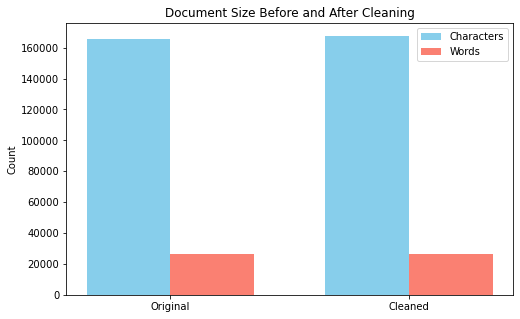

In [9]:
# Compute stats
stats = {
    "Original": {"chars": len(text), "words": len(text.split())},
    "Cleaned": {"chars": len(cleaned), "words": len(cleaned.split())}
}

labels = list(stats.keys())
chars = [stats[label]["chars"] for label in labels]
words = [stats[label]["words"] for label in labels]

# Plot
fig, ax = plt.subplots(figsize=(8,5))

bar_width = 0.35
x = range(len(labels))

# Two bars for chars and words
ax.bar(x, chars, width=bar_width, label='Characters', color='skyblue')
ax.bar([i + bar_width for i in x], words, width=bar_width, label='Words', color='salmon')

ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(labels)
ax.set_ylabel('Count')
ax.set_title('Document Size Before and After Cleaning')
ax.legend()

plt.show()


In [10]:
# compute stats
original_chars, original_words = len(text), len(text.split())
cleaned_chars, cleaned_words = len(cleaned), len(cleaned.split())

# print as table
print(f"{'Metric':<12} | {'Original':>10} | {'Cleaned':>10}")
print("-" * 36)
print(f"{'Characters':<12} | {original_chars:>10} | {cleaned_chars:>10}")
print(f"{'Words':<12} | {original_words:>10} | {cleaned_words:>10}")


Metric       |   Original |    Cleaned
------------------------------------
Characters   |     165696 |     167563
Words        |      26098 |      26098


The cleaning step successfully reduces minor noise without compromising meaningful content, making the document suitable for further processing.

### Spliting Text into Chunks

In [11]:
def split_text_into_chunks(text, max_chars=500, overlap=50):
    """
    Splits text into chunks of max_chars with optional overlap.
    Keeps sentences intact (splits on punctuation).
    """
    # Split text into sentences
    sentences = re.split(r'(?<=[.!?]) +', text)
    
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= max_chars:
            current_chunk += " " + sentence if current_chunk else sentence
        else:
            chunks.append(current_chunk.strip())
            # start new chunk with overlap
            current_chunk = " ".join(current_chunk.split()[-overlap:]) + " " + sentence if overlap else sentence

    # Add last chunk
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

# Apply chunking
chunks = split_text_into_chunks(cleaned, max_chars=500, overlap=50)

print("Number of chunks:", len(chunks))
print("\n--- Sample chunk ---\n")
print(chunks[0])


Number of chunks: 320

--- Sample chunk ---

OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34

2.4.1 Resident Foreign Nationals 34

2.4.2 Account Opening Requirements for Non-Resident Foreign Nationals (As Per CBK Prudential Guidelines).


A histogram to show if there are outliers in the Chunks

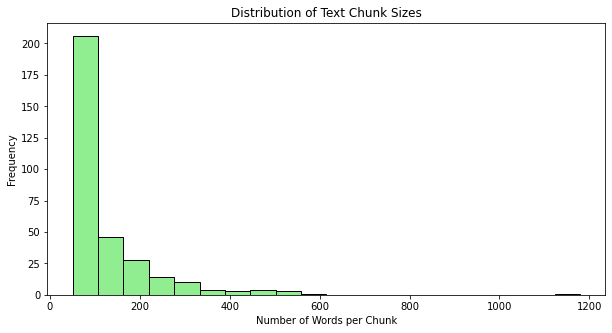

In [12]:
# Compute number of words in each chunk
chunk_lengths = [len(chunk.split()) for chunk in chunks]

# Create a histogram
plt.figure(figsize=(10,5))
plt.hist(chunk_lengths, bins=20, color='lightgreen', edgecolor='black')
plt.xlabel("Number of Words per Chunk")
plt.ylabel("Frequency")
plt.title("Distribution of Text Chunk Sizes")
plt.show()


The chunk size distribution is centered around ~500 words, which aligns well with our target for embeddings. This indicates a mostly consistent chunking strategy. However, the histogram reveals a tail of smaller chunks (<200 words) and some oversized chunks (>800 words). These could impact efficiency: small chunks may not carry enough semantic content, while large ones risk exceeding model context limits. 

### Handling outliers in chunk sizes
- Merge very small chunks with their neighbors (to avoid low-content pieces).
- Split very large chunks into smaller ones (to stay within context limits).

In [14]:
def balance_chunks(chunks, min_words=300, max_words=600):
    """
    Adjust chunk sizes by merging small chunks and splitting large ones.
    
    Args:
        chunks (list[str]): List of text chunks.
        min_words (int): Minimum acceptable word count.
        max_words (int): Maximum acceptable word count.
        
    Returns:
        list[str]: Adjusted list of chunks.
    """
    adjusted_chunks = []
    buffer = ""

    for chunk in chunks:
        words = chunk.split()

        # Case 1: Oversized chunk → split into smaller pieces
        if len(words) > max_words:
            for i in range(0, len(words), max_words):
                adjusted_chunks.append(" ".join(words[i:i+max_words]))

        # Case 2: Small chunk → merge with buffer until it's big enough
        elif len(words) < min_words:
            buffer += " " + " ".join(words)
            if len(buffer.split()) >= min_words:
                adjusted_chunks.append(buffer.strip())
                buffer = ""

        # Case 3: Normal chunk → keep as is
        else:
            adjusted_chunks.append(" ".join(words))

    # Flush any leftover buffer
    if buffer.strip():
        adjusted_chunks.append(buffer.strip())

    return adjusted_chunks


# Example usage
balanced_chunks = balance_chunks(chunks, min_words=300, max_words=600)

print(f"Original chunks: {len(chunks)}")
print(f"Balanced chunks: {len(balanced_chunks)}")


Original chunks: 320
Balanced chunks: 109


## Vectorization 

The cleaned text is transformed into sentence embeddings, which convert sentences into dense vectors that capture meaning rather than just word counts. This enables semantic search and NLP tasks, allowing the system to compare and retrieve text based on context and intent, not just keywords.


### Transformer embeddings(MiniLM)

At this step, the project uses transformer embeddings with MiniLM (all-MiniLM-L6-v2) to represent the KYC policy text. The document is split into smaller chunks, and each chunk is encoded into a 384-dimensional vector that captures its semantic meaning. These embeddings enable advanced tasks such as semantic search, similarity comparison, and document retrieval, while keeping the process efficient and scalable.

In [20]:
# Loading MiniLM model 
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
embeddings = model.encode(chunks, convert_to_numpy=True)

print("Number of chunks:", len(chunks))
print("Embedding dimension:", embeddings.shape[1])


Number of chunks: 320
Embedding dimension: 384


The project produced 320 chunks, meaning the document was split into 320 text segments. Each chunk is represented by a single embedding vector of 384 dimensions, which is the fixed size of MiniLM embeddings. In effect, the output is a matrix of shape 320 × 384: one embedding per chunk, with 384 values capturing its meaning.

### Saving Chunks with Embeddings
At this step, the code pairs each text chunk with its embedding and stores them in a list of dictionaries. This list is then saved to SEC5_embeddings.pkl using pickle, allowing the results to be reloaded later without recomputing.

In [21]:
# Combine text and embeddings
data = [{"chunk": chunk, "embedding": emb} for chunk, emb in zip(chunks, embeddings)]

# Define output path
out_path = r"Data/SEC5_embeddings.pkl"

# Save to file
with open(out_path, "wb") as f:
    pickle.dump(data, f)

print(f" Saved {len(data)} chunks with embeddings to {out_path}")


 Saved 320 chunks with embeddings to Data/SEC5_embeddings.pkl


### Indexing / Storing
Preparing your embeddings for fast retrieval, often using a vector database or a similarity search library-the next step is to load them and store them in a structure that allows fast semantic search.

Common approach using FAISS (Facebook AI Similarity Search) for efficient vector indexing:
 
 - We load the saved embeddings from the previous step.

- Convert them to a NumPy array for FAISS.

- Build a FAISS index for fast nearest-neighbor search.

- Save the index for later use without recomputing embeddings.


In [22]:
# Load saved embeddings
with open(r"Data/SEC5_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

# Extract embeddings as a NumPy array
embeddings = np.array([item["embedding"] for item in data], dtype='float32')
print("Embeddings shape:", embeddings.shape)

# Build FAISS index 
dimension = embeddings.shape[1]  # 384 for MiniLM-L6-v2
index = faiss.IndexFlatL2(dimension)  # L2 distance; use IndexFlatIP for cosine similarity
index.add(embeddings)
print("Number of vectors in index:", index.ntotal)

# save index to disk 
faiss.write_index(index, r"Data/SEC5_faiss.index")
print("FAISS index saved to Data/SEC5_faiss.index")


Embeddings shape: (320, 384)
Number of vectors in index: 320
FAISS index saved to Data/SEC5_faiss.index


The results show that 320 text chunks were converted into 384-dimensional embeddings, all stored in the FAISS index. The index was saved successfully, meaning the document is ready for fast semantic search and retrieval.

In [26]:
#  Load embeddings 
with open(r"Data/SEC5_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

chunks = [d["chunk"] for d in data]
embeddings = np.array([d["embedding"] for d in data], dtype='float32')

# Build FAISS index 
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance
index.add(embeddings)
print(f"FAISS index built with {index.ntotal} vectors")


FAISS index built with 320 vectors


### Querying data 

In [31]:
# Queries the index
query = "KYC requirements"
model = SentenceTransformer("all-MiniLM-L6-v2")

query_emb = model.encode([query], convert_to_numpy=True).astype('float32')

k = 5  # top-k results
distances, indices = index.search(query_emb, k)

# --- Display results ---
top_chunks = [chunks[i] for i in indices[0]]
top_distances = distances[0]

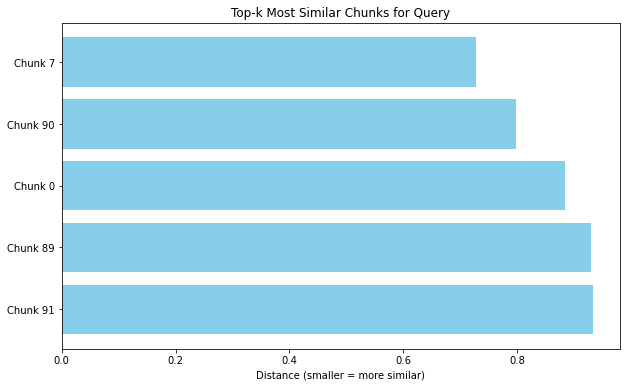


Rank 1 | Distance: 0.7283
received. ACCOUNT OPENING REQUIREMENTS Know Your Customer (KYC) KYC at the point of account opening is crucial and staff shall perform a thorough KYC for the persons opening the account and understand the nature of their business. Staff shall ensure that all accounts opened meet the legal requiremen...

Rank 2 | Distance: 0.7976
Conditions Once the customer signs on the Terms and Condition, select Yes and click Submit. This will take you to the next step of attaching KYC document e.g. Affidavit or license Note: The printed mandate that has been confirmed and signed by the customer shall not be forwarded to BOS. The mandate ...

Rank 3 | Distance: 0.8848
OPENING OF ACCOUNTS

TABLE OF CONTENTS

1 INTRODUCTION 11

1.1 General 11

2 ACCOUNT OPENING REQUIREMENTS 11

2.1 Know Your Customer (KYC) 11

2.2 Account Opening Requirements on Referee 11

2.3 Documentation Required for Account Opening 12

2.4 Account Opening Requirements for Foreign Nationals 34
...

Rank 4

In [32]:
plt.figure(figsize=(10,6))
plt.barh(range(k), top_distances, color='skyblue')
plt.yticks(range(k), [f"Chunk {i}" for i in indices[0]])
plt.gca().invert_yaxis()
plt.xlabel("Distance (smaller = more similar)")
plt.title("Top-k Most Similar Chunks for Query")
plt.show()

# Print chunks for reference
for rank, (chunk, dist) in enumerate(zip(top_chunks, top_distances), start=1):
    print(f"\nRank {rank} | Distance: {dist:.4f}\n{chunk[:300]}...")  # preview first 300 chars

4. Modeling (Chatbot Logic)


The goal here is to take a user query, find the most relevant chunks in your document using embeddings, and optionally generate a response (if using a language model).

Core Steps:

Take user query and generate its embedding.

Search the index for top-k similar chunks.

Retrieve these chunks as context.

LLaMA model

Step 4.1 – Prepare the LLaMA Model